# Extended network analysis

---

## 0. Environmental setup

In [1]:
import numpy as np
import matplotlib as mpl
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import pandas as pd
from venn import venn
from sklearn.metrics import adjusted_mutual_info_score
from tqdm.notebook import tqdm
import seaborn as sns

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def compare_louvain_clustering(
    graph, resolutions, reference, selection=None, random_state=1234
):
    amis = []
    for resolution in tqdm(resolutions):
        louvain_clusters = get_louvain_clustering(
            graph, resolution=resolution, selection=selection, random_state=random_state
        )
        nodes = set(louvain_clusters.index).intersection(reference.index)
        amis.append(
            adjusted_mutual_info_score(
                np.array(louvain_clusters.loc[nodes]).ravel(),
                np.array(reference.loc[nodes]).ravel(),
            )
        )
    return pd.DataFrame({"resolution": resolutions, "ami": amis})

<IPython.core.display.Javascript object>

In [3]:
def get_louvain_clustering(graph, selection=None, resolution=1, random_state=1234):
    nodes = []
    clusters = []
    cluster = 0
    if selection is None:
        selection = set(graph.nodes())
    comms = nx_comm.louvain_communities(graph, resolution=resolution, seed=random_state)
    for comm in comms:
        filtered = list(comm.intersection(selection))
        nodes.extend(filtered)
        clusters.extend([cluster] * len(filtered))
        cluster += 1
    return pd.DataFrame(clusters, index=nodes, columns=["cluster"])

<IPython.core.display.Javascript object>

---

## 1. Read in data

First, we read in the inferred networks.

In [60]:
cmap_abssig_mis_ia = nx.read_gpickle(
    "../../../data/ppi/inference_results/cmap_abssig_mis_sol_cv.pkl"
)
print(cmap_abssig_mis_ia)

cmap_abssig_ccle_spearman_ia = nx.read_gpickle(
    "../../../data/ppi/inference_results/cmap_abssig_ccle_spearmanr_sol_cv.pkl"
)
print(cmap_abssig_ccle_spearman_ia)

ccle_abslogfc_ccle_mis_ia = nx.read_gpickle(
    "../../../data/ppi/inference_results/ccle_abslogfc_mis_sol_cv.pkl"
)
print(ccle_abslogfc_ccle_mis_ia)

ccle_abslogfc_ccle_spearman_ia = nx.read_gpickle(
    "../../../data/ppi/inference_results/ccle_abslogfc_ccle_spearmanr_sol_cv.pkl"
)
print(ccle_abslogfc_ccle_spearman_ia)

cmap_abssig_cmap_spearman_ia = nx.read_gpickle(
    "../../../data/ppi/inference_results/cmap_abssig_cmap_spearmanr_sol_cv.pkl"
)
print(cmap_abssig_cmap_spearman_ia)

filtered_cmap_abssig_ccle_spearmanr_ia = nx.read_gpickle(
    "../../../data/ppi/inference_results/filtered_cmap_abssig_ccle_spearmanr_sol_cv.pkl"
)
print(filtered_cmap_abssig_ccle_spearmanr_ia)

Graph named 'cmap_abssig_mis_sol' with 792 nodes and 6150 edges
Graph named 'cmap_abssig_ccle_spearmanr_sol' with 357 nodes and 1138 edges
Graph named 'ccle_abslogfc_mis_sol' with 291 nodes and 1850 edges
Graph named 'ccle_abslogfc_ccle_spearmanr_sol' with 151 nodes and 299 edges
Graph named 'cmap_abssig_cmap_spearmanr_sol' with 1149 nodes and 4232 edges
Graph named 'filtered_cmap_abssig_ccle_spearmanr_sol' with 262 nodes and 479 edges


<IPython.core.display.Javascript object>

Second, we load a number of required gene sets.

In [182]:
mean_physical_clusters = pd.read_csv(
    "../../../data/other/mean_physical_clusters.csv", index_col=0
)

<IPython.core.display.Javascript object>

---

## 2. Exploratory data analysis

### 2.1. Network similarity

As a first step, we are interested in the difference between the individual inferred interactome candidates. To this end, we look at the similarities of the node covered by each of those networks.

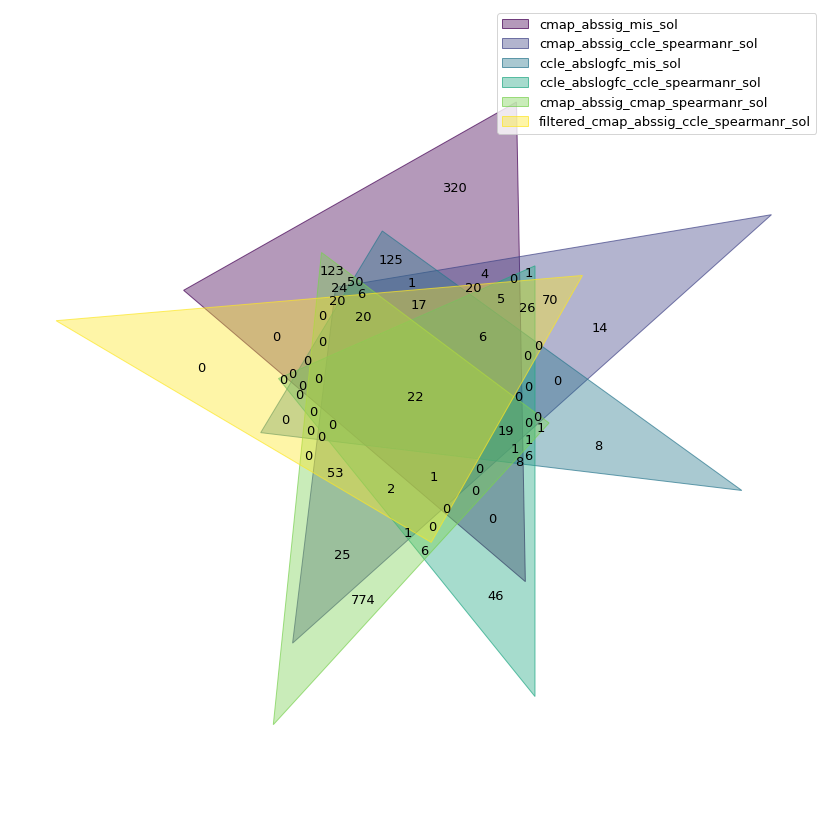

<IPython.core.display.Javascript object>

In [61]:
ax = venn(
    {
        cmap_abssig_mis_ia.name: set(cmap_abssig_mis_ia.nodes()),
        cmap_abssig_ccle_spearman_ia.name: set(cmap_abssig_ccle_spearman_ia.nodes()),
        ccle_abslogfc_ccle_mis_ia.name: set(ccle_abslogfc_ccle_mis_ia.nodes()),
        ccle_abslogfc_ccle_spearman_ia.name: set(
            ccle_abslogfc_ccle_spearman_ia.nodes()
        ),
        cmap_abssig_cmap_spearman_ia.name: set(cmap_abssig_cmap_spearman_ia.nodes()),
        filtered_cmap_abssig_ccle_spearmanr_ia.name: set(
            filtered_cmap_abssig_ccle_spearmanr_ia.nodes()
        ),
    },
    legend_loc="best",
    figsize=[15, 15],
)

As indicated above the individual network candidates are fairly dissimilar as each only roughly 40-50% of the nodes are covered in any other network.

---

### 2.2. Network clustering

Next, we will cluster the network using Louvain clustering and look at the agreement of the clustering of the physical space using the estimated regulators. 

In [184]:
resolutions = np.arange(0.1, 10, 0.1)
cmap_abssig_mis_ia_cluster_comp = compare_louvain_clustering(
    graph=cmap_abssig_mis_ia, resolutions=resolutions, reference=mean_physical_clusters
)
cmap_abssig_mis_ia_cluster_comp["graph"] = "cmap_abssig_mis_ia"
cmap_abssig_ccle_spearman_ia_cluster_comp = compare_louvain_clustering(
    graph=cmap_abssig_ccle_spearman_ia,
    resolutions=resolutions,
    reference=mean_physical_clusters,
)
cmap_abssig_ccle_spearman_ia_cluster_comp["graph"] = "cmap_abssig_ccle_spearman_ia"
ccle_abslogfc_ccle_mis_ia_cluster_comp = compare_louvain_clustering(
    graph=ccle_abslogfc_ccle_mis_ia,
    resolutions=resolutions,
    reference=mean_physical_clusters,
)
ccle_abslogfc_ccle_mis_ia_cluster_comp["graph"] = "ccle_abslogfc_ccle_mis_ia"
ccle_abslogfc_ccle_spearman_cluster_comp = compare_louvain_clustering(
    graph=ccle_abslogfc_ccle_spearman_ia,
    resolutions=resolutions,
    reference=mean_physical_clusters,
)
ccle_abslogfc_ccle_spearman_cluster_comp["graph"] = "ccle_abslogfc_ccle_spearman"

cmap_abssig_cmap_spearman_ia_cluster_comp = compare_louvain_clustering(
    graph=cmap_abssig_cmap_spearman_ia,
    resolutions=resolutions,
    reference=mean_physical_clusters,
)
cmap_abssig_cmap_spearman_ia_cluster_comp["graph"] = "cmap_abssig_cmap_spearman_ia"

filtered_cmap_abssig_ccle_spearmanr_ia_cluster_comp = compare_louvain_clustering(
    graph=filtered_cmap_abssig_ccle_spearmanr_ia,
    resolutions=resolutions,
    reference=mean_physical_clusters,
)
filtered_cmap_abssig_ccle_spearmanr_ia_cluster_comp[
    "graph"
] = "filtered_cmap_abssig_ccle_spearmanr_ia"

cluster_comps = pd.concat(
    [
        cmap_abssig_mis_ia_cluster_comp,
        cmap_abssig_ccle_spearman_ia_cluster_comp,
        ccle_abslogfc_ccle_mis_ia_cluster_comp,
        ccle_abslogfc_ccle_spearman_cluster_comp,
        cmap_abssig_cmap_spearman_ia_cluster_comp,
        # filtered_cmap_abssig_ccle_spearmanr_ia_cluster_comp,
    ]
)

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

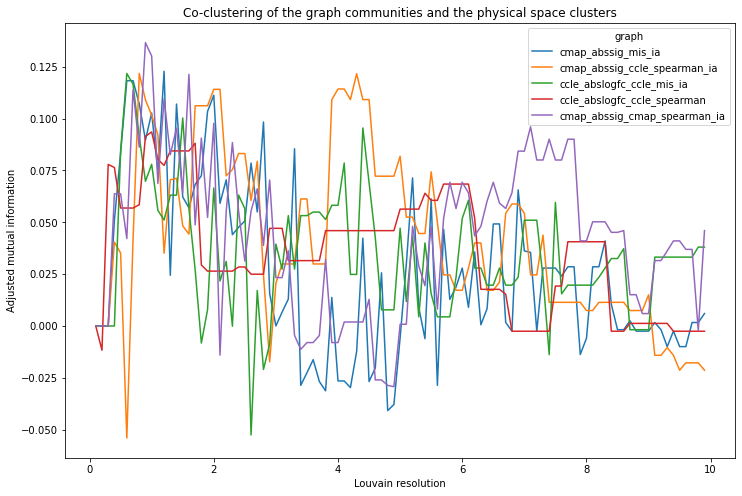

<IPython.core.display.Javascript object>

In [188]:
fig, ax = plt.subplots(figsize=[12, 8])
ax = sns.lineplot(
    data=cluster_comps, x="resolution", y="ami", hue="graph", palette="tab10"
)
ax.set_xlabel("Louvain resolution")
ax.set_ylabel("Adjusted mutual information")
ax.set_title("Co-clustering of the graph communities and the physical space clusters")
plt.show()

The plots above indicate that the clustering in the phyiscal space is best reflected in the communities identified in the graph that has been constructed using the maximum mod-z statistic as a node prize and the spearman correlation from the single-cell data set.

---

### 2.3. Neighborhood analysis

Next, we are interested in understanding how much of the neighborhood is shared for different levels of k-hop neighborhoods in the inferred graphs. The idea is to understand how much of the shared signaling cascade is covered in the inferred network for different levels of neighborhood sizes. We are additionally interested in understanding the size of those shared neighborhoods for any target pair that ends up in the same cluster in the physical space vs. those that cluster differently.

To this end, we will compute the IoU of the any pair of genes encoded in the physical space estimate for varying k-hop neighborhoods. We will baseline the corresponding curves by taking a random subsample of genes that are not encoded in the physical space and assess the IoU in a similar fashion as described above.

In [71]:
def compute_iou_khop_neighbors(graph, source, target, k):
    source_knns = set(
        list(nx.single_source_shortest_path_length(graph, source, cutoff=k).keys())
    )
    target_knns = set(
        list(nx.single_source_shortest_path_length(graph, target, cutoff=k).keys())
    )
    return len(source_knns.intersection(target_knns)) / len(
        source_knns.union(target_knns)
    )

<IPython.core.display.Javascript object>

In [72]:
def run_khop_analysis(graph, reference, ks, random_state=1234):
    np.random.seed(random_state)
    data = {"source": [], "target": [], "k": [], "group": [], "iou": []}
    covered_nodes = list(set(graph.nodes()).intersection(reference.index))
    background_nodes = list(set(graph.nodes()) - set(reference.index))
    background_nodes = list(
        np.random.choice(background_nodes, size=len(covered_nodes), replace=False)
    )
    for k in tqdm(ks):
        for i in range(len(covered_nodes) - 1):
            for j in range(i + 1, len(covered_nodes)):
                source = covered_nodes[i]
                target = covered_nodes[j]
                if len(np.unique(reference.loc[[source, target]])) == 1:
                    group = "within cluster"
                else:
                    group = "between clusters"
                iou = compute_iou_khop_neighbors(graph, source, target, k)
                data["source"].append(source)
                data["target"].append(target)
                data["k"].append(k)
                data["group"].append(group)
                data["iou"].append(iou)
        for i in range(len(background_nodes) - 1):
            for j in range(i + 1, len(background_nodes)):
                source = background_nodes[i]
                target = background_nodes[j]
                group = "n/a"
                iou = compute_iou_khop_neighbors(graph, source, target, k)
                data["source"].append(source)
                data["target"].append(target)
                data["k"].append(k)
                data["group"].append(group)
                data["iou"].append(iou)
    return pd.DataFrame(data)

<IPython.core.display.Javascript object>

In [42]:
ks = np.arange(1, 10)
cmap_abssig_ccle_spearman_ia_knbrs_comp = run_khop_analysis(
    cmap_abssig_ccle_spearman_ia, mean_physical_clusters, ks
)

  0%|          | 0/9 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

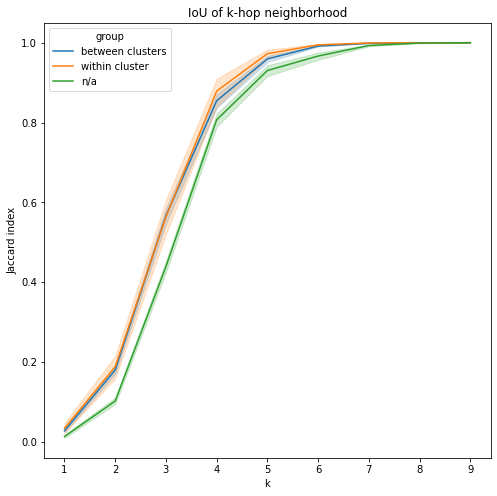

<IPython.core.display.Javascript object>

In [45]:
fig, ax = plt.subplots(figsize=[8, 8])
ax = sns.lineplot(
    data=cmap_abssig_ccle_spearman_ia_knbrs_comp, x="k", y="iou", hue="group"
)
ax.set_ylabel("Jaccard index")
ax.set_title("IoU of k-hop neighborhood")
plt.show()

In [73]:
ks = np.arange(1, 10)
filtered_cmap_abssig_ccle_spearmanr_ia_knbrs_comp = run_khop_analysis(
    filtered_cmap_abssig_ccle_spearmanr_ia, mean_physical_clusters, ks
)

  0%|          | 0/9 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

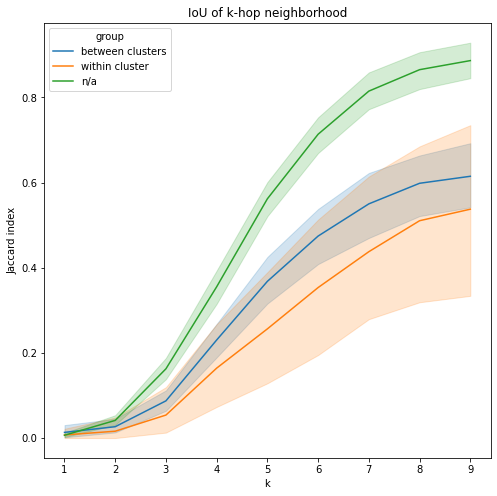

<IPython.core.display.Javascript object>

In [74]:
fig, ax = plt.subplots(figsize=[8, 8])
ax = sns.lineplot(
    data=filtered_cmap_abssig_ccle_spearmanr_ia_knbrs_comp, x="k", y="iou", hue="group"
)
ax.set_ylabel("Jaccard index")
ax.set_title("IoU of k-hop neighborhood")
plt.show()

,source,target,k,group,iou
0,TSC2,PRKCE,1,between clusters,0.000000
1,TSC2,RELB,1,between clusters,0.000000
2,TSC2,TRAF2,1,between clusters,0.000000
3,TSC2,DIABLO,1,between clusters,0.000000
4,TSC2,JUN,1,between clusters,0.000000
...,...,...,...,...,...
3073,UBE2C,EXOSC4,9,n/a,0.980159
3074,UBE2C,EEF1A1,9,n/a,0.996032
3075,NPM1,EXOSC4,9,n/a,0.980159
3076,NPM1,EEF1A1,9,n/a,0.996032


<IPython.core.display.Javascript object>

In [94]:
cmap_abssig_ccle_spearman_ia_knbrs_comp.loc[
    (
        (cmap_abssig_ccle_spearman_ia_knbrs_comp.source == "JUN")
        | (cmap_abssig_ccle_spearman_ia_knbrs_comp.target == "JUN")
    )
    & (cmap_abssig_ccle_spearman_ia_knbrs_comp.k == 1)
].sort_values("iou", ascending=False).head()

,source,target,k,group,iou
175,CEBPA,JUN,1,within cluster,0.214286
231,JUN,ATF4,1,between clusters,0.185185
218,JUN,SMAD4,1,between clusters,0.108108
210,JUN,CASP8,1,between clusters,0.107143
224,JUN,ERG,1,within cluster,0.100000


<IPython.core.display.Javascript object>

### Feature propagation

In [117]:
A = nx.to_pandas_adjacency(cmap_abssig_ccle_spearman_ia)
nodes = list(A.index)

<IPython.core.display.Javascript object>

In [218]:
print(
    sorted(
        list(
            set(cmap_abssig_ccle_spearman_ia.nodes()).intersection(
                mean_physical_clusters.index
            )
        )
    )
)

['ATF4', 'BAX', 'BCL2L11', 'BRAF', 'CASP8', 'CDC42', 'CDKN1A', 'CEBPA', 'CREB1', 'DIABLO', 'E2F1', 'ELK1', 'ERG', 'FGFR3', 'FOXO1', 'GLI1', 'HRAS', 'IRAK4', 'JUN', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK7', 'MYD88', 'PIK3R2', 'PRKACA', 'PRKCE', 'RAF1', 'RELB', 'RHOA', 'SMAD4', 'SMO', 'SRC', 'SREBF1', 'TRAF2', 'TSC2', 'WWTR1']


<IPython.core.display.Javascript object>

In [115]:
l1000_genes = set(
    list(
        pd.read_csv(
            "../../../data/other/genesets/l1000.txt", index_col=0, header=None
        ).index
    )
)

<IPython.core.display.Javascript object>

In [116]:
cmap_data = pd.read_csv("../../../data/gex/cmap/mean_l5_signatures.csv", index_col=0)
cmap_gene_set = set(cmap_data.columns)

<IPython.core.display.Javascript object>

In [147]:
features = pd.DataFrame(
    np.zeros((len(nodes), len(l1000_genes))), index=nodes, columns=l1000_genes
)
feature_mask = pd.DataFrame(np.zeros_like(features), index=nodes, columns=l1000_genes)
for node in nodes:
    try:
        features.loc[node] = cmap_data.loc[node, l1000_genes]
        feature_mask.loc[node] = np.ones(len(l1000_genes))
    except KeyError:
        pass
features.head()

,APPBP2,FOSL1,GTF2A2,NUSAP1,HEATR1,NCK1,YTHDF1,PRR7,ARFIP2,ALDOC,...,CDC25A,XPNPEP1,ATP11B,FKBP14,OXA1L,CCNA1,GNB5,DPH2,SNX11,IL1B
CRMP1,0.0000,0.00000,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.00000,0.0000,...,0.0000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.0000,0.00000,0.0000
RBL1,0.0000,0.00000,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.00000,0.0000,...,0.0000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.0000,0.00000,0.0000
RPS7,0.0000,0.00000,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.00000,0.0000,...,0.0000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.0000,0.00000,0.0000
RPS19,0.0000,0.00000,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.00000,0.0000,...,0.0000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.0000,0.00000,0.0000
NFKBIA,-1.3318,-1.06045,0.4461,-5.10175,-1.9862,1.0666,0.6595,-0.1011,0.30225,0.6176,...,0.2607,1.0651,3.96555,0.1582,0.1877,1.10325,0.74515,-0.4578,0.36255,-0.9832


<IPython.core.display.Javascript object>

In [207]:
jun_feats = features.loc["JUN"]
features.loc["JUN"] = np.zeros_like(jun_feats)
feature_mask.loc["JUN"] = np.zeros_like(jun_feats)

<IPython.core.display.Javascript object>

---

In [208]:
A_arr = np.array(A) + np.identity(len(A))
d = np.sum(A_arr, axis=1)
# Invert the square root of the degree
d = 1 / np.sqrt(d)
# And build the square root inverse degree matrix
D = np.diag(d)
# Return the Normalized Adjacency
A_tilde = D @ A_arr @ D
X = np.array(features)
feat_mask = np.array(feature_mask).astype(bool)

<IPython.core.display.Javascript object>

In [209]:
X_hat = X
X_new = np.zeros_like(X_hat)
# while np.allclose(X_hat, X_new, atol=1e-12, rtol=1e-9) == False:
for i in tqdm(range(100000)):
    X_new = A_tilde @ X_hat
    X_new[feat_mask] = X[feat_mask]
    X_hat = X_new

  0%|          | 0/100000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [210]:
features_imp = pd.DataFrame(X_hat, index=features.index, columns=features.columns)
features_imp

,APPBP2,FOSL1,GTF2A2,NUSAP1,HEATR1,NCK1,YTHDF1,PRR7,ARFIP2,ALDOC,...,CDC25A,XPNPEP1,ATP11B,FKBP14,OXA1L,CCNA1,GNB5,DPH2,SNX11,IL1B
CRMP1,-0.240660,0.283739,-0.667997,-1.471096,-0.376579,0.426156,0.413389,-0.423711,-0.267412,0.222074,...,-0.443127,-0.642715,0.718845,0.013713,-0.727707,0.561649,0.175070,-0.391465,0.157805,0.258537
RBL1,-0.131085,0.231400,-0.154416,-0.998250,-0.334015,0.302287,0.239219,-0.654915,-0.255616,0.038553,...,-0.243326,0.086835,0.507064,-0.271194,-0.768413,0.451826,0.184228,-0.407211,0.042884,0.129624
RPS7,-0.377919,-0.064408,-0.054716,-1.520428,-0.514919,0.447634,0.365254,-0.488703,-0.135284,0.299775,...,-0.197333,-0.091795,0.838606,0.057022,-0.371062,0.194360,0.311276,-0.213187,0.138828,0.082241
RPS19,-0.404163,-0.064839,-0.067870,-1.639812,-0.556518,0.481788,0.395307,-0.535922,-0.155655,0.320580,...,-0.222450,-0.104811,0.905650,0.065283,-0.415234,0.217780,0.335818,-0.237276,0.150096,0.096101
NFKBIA,-1.331800,-1.060450,0.446100,-5.101750,-1.986200,1.066600,0.659500,-0.101100,0.302250,0.617600,...,0.260700,1.065100,3.965550,0.158200,0.187700,1.103250,0.745150,-0.457800,0.362550,-0.983200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ADRB2,-0.322472,0.378377,-0.520047,-1.259089,-0.180381,0.229222,0.355522,-0.282646,-0.243379,-0.004961,...,-0.267469,-0.670033,0.483089,0.018370,-0.484873,0.342383,0.008754,-0.358834,0.158240,0.172125
CEBPA,-0.338400,-0.549925,0.011050,-1.635125,0.462775,-0.103625,-0.707500,-4.945850,-1.235675,-0.694950,...,-0.555450,-0.125775,0.908875,-1.585400,-0.974750,1.506450,0.321200,-1.475750,0.037425,4.336850
FYN,-0.778507,0.573193,-1.019956,-1.111644,-0.497720,0.708041,0.393250,-0.077946,-0.128085,0.029643,...,-0.467581,-0.058646,0.454637,0.385394,-0.408692,0.401884,-0.143325,0.084321,0.069953,0.183001
OSGEP,-0.103603,-0.102695,-0.350473,-0.082616,-0.452909,0.000012,0.118821,-0.591083,-0.747971,0.062863,...,-0.510425,-0.091556,0.390886,0.087078,-0.214472,0.253536,0.136047,-0.751898,-0.124427,0.231346


<IPython.core.display.Javascript object>

In [213]:
cmap_data.loc["JUN", l1000_genes]

APPBP2    0.808200
FOSL1    -0.594400
GTF2A2   -1.806800
NUSAP1    1.203275
HEATR1   -1.229775
            ...   
CCNA1     1.269800
GNB5     -0.796125
DPH2     -1.080250
SNX11    -0.428225
IL1B      0.351850
Name: JUN, Length: 978, dtype: float64

<IPython.core.display.Javascript object>

In [211]:
features_imp.loc["JUN"]

APPBP2   -0.167651
FOSL1    -0.137550
GTF2A2   -0.145587
NUSAP1   -1.143181
HEATR1   -0.522582
            ...   
CCNA1     0.567342
GNB5      0.247487
DPH2     -0.485255
SNX11     0.271629
IL1B      0.337349
Name: JUN, Length: 978, dtype: float64

<IPython.core.display.Javascript object>

In [215]:
from scipy.stats import spearmanr

spearmanr(cmap_data.loc["JUN", l1000_genes], features_imp.loc["JUN"])

SpearmanrResult(correlation=0.28471958473888803, pvalue=1.0732819650942514e-19)

<IPython.core.display.Javascript object>

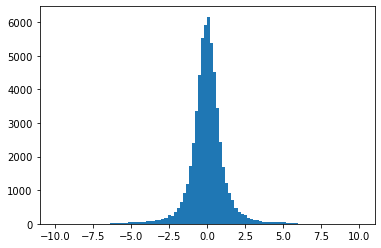

<IPython.core.display.Javascript object>

In [202]:
plt.hist(X_hat[feat_mask], bins=100)
plt.show()

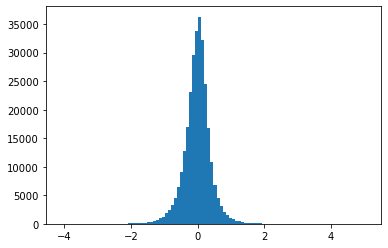

<IPython.core.display.Javascript object>

In [203]:
plt.hist(X_hat[~feat_mask], bins=100)
plt.show()